# My approach:

1. Data Cleaning

    1. Remove nodes that have more neighbourhood, in that case, we know, celebrities/busineessman have more followers, but the probability to become friend is very lower.
    2. Considering this concept, i remove all the nodes from training nodes which have newighbours more than 60.
    3. Change data types of columns, which can describe them better like int8, float16 etc.

2. Feature enginerring, using **Graph** based supervised and unsupervised methods


    1. Unsupervised features
        - Resource Allocation
        - jaccard Coefficient
        - Adamic Adar
        - Prefrential attachment

    2. Katz Rank features
        - weighted
        - unweighted

    3. Page Rank feature

    4. User Specific features
        - create sparse incidence matrix from graph
        - Run SVD on top of that, to extract low dimensional space vector

3. More Feature engineering
    - Check the nodes belongs to same community, so using that we have 13 more features
    - Using distance based method, can be very helpful, Didn't includes, becuase of memory constaint

**Using all the above feature engineering, i got 143 features**

4. Model building
    - Used stratified sampling for cv of 5 folds
    - used Graident Based Model (LightGBM, CatBoost, XGBoost)
    - Final prediction is blending of all three models.
    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

train_df = pd.read_csv('data/train/train.csv')

train_df.node1_id = train_df.node1_id.astype('int32')
train_df.node2_id = train_df.node2_id.astype('int32')
train_df.is_chat  = train_df.is_chat.astype('int8')


test_df = pd.read_csv('data/test.csv')

test_df.id = test_df.id.astype('int32')
test_df.node1_id = test_df.node1_id.astype('int32')
test_df.node2_id = test_df.node2_id.astype('int32')


grouping_idx = train_df.groupby('node1_id')['node2_id'].count() > 60
train_df = train_df.iloc[grouping_idx[grouping_idx == False].index]


user_df  = pd.read_csv('data/train/user_features.csv')

user_df.node_id  = user_df.node_id.astype('int32')
user_df.f1       = user_df.f1.astype('int8')
user_df.f2       = user_df.f2.astype('int8')
user_df.f3       = user_df.f3.astype('int8')
user_df.f4       = user_df.f4.astype('int8')
user_df.f5       = user_df.f5.astype('int8')
user_df.f6       = user_df.f6.astype('int8')
user_df.f7       = user_df.f7.astype('int8')
user_df.f8       = user_df.f8.astype('int8')
user_df.f9       = user_df.f9.astype('int8')
user_df.f10      = user_df.f10.astype('int8')
user_df.f11      = user_df.f11.astype('int8')
user_df.f12      = user_df.f12.astype('int8')
user_df.f13      = user_df.f13.astype('int8')


train_df.shape, test_df.shape, user_df.shape

((3392012, 3), (11776968, 3), (8264276, 14))

In [2]:
import re

def comma_me(amount):
    amount = str(amount)
    orig = amount
    new = re.sub("^(-?\d+)(\d{3})", '\g<1>,\g<2>', amount)
    if orig == new:
        return new
    else:
        return comma_me(new)



In [3]:
page_rank = pd.read_csv('data/1_ranking_df.csv')
combine_all_new1 = pd.read_csv('data/1_combine_all.csv')
katz1 = pd.read_csv('data/1_katzing_11.csv')
katz2 = pd.read_csv('data/1_katzing_22.csv')

print("page_rank: ".ljust(10), comma_me(page_rank.shape[0]),page_rank.shape[1])
print("jaccard: ".ljust(10), comma_me(combine_all_new1.shape[0]), combine_all_new1.shape[1])
print("katz1: ".ljust(10), comma_me(katz1.shape[0]), katz1.shape[1])
print("katz2: ".ljust(10), comma_me(katz2.shape[0]), katz2.shape[1])


page_rank:  5,382,233 2
jaccard:   15,168,980 6
katz1:     5,382,233 2
katz2:     5,382,233 2


In [4]:
combine_all_new1.iloc[:,-4:].describe()

,resource_alloc,jaccard_coeff,preferential_attach,adamic_adar
count,1.516898e+07,1.516898e+07,1.516898e+07,1.516898e+07
mean,1.969777e-04,1.542103e-02,8.917707e-04,4.836023e-03
std,1.647244e-03,9.182169e-02,1.961769e-03,1.522843e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,1.411438e-04,0.000000e+00
50%,0.000000e+00,0.000000e+00,4.234314e-04,0.000000e+00
75%,0.000000e+00,0.000000e+00,1.034737e-03,0.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [6]:
combine_all_new1.resource_alloc     = combine_all_new1.resource_alloc.astype('float16')
combine_all_new1.jaccard_coeff      = combine_all_new1.jaccard_coeff.astype('float16')
combine_all_new1.adamic_adar        = combine_all_new1.adamic_adar.astype('float16')
combine_all_new1.preferential_attach= combine_all_new1.preferential_attach.astype('float16')


In [7]:
katzing = pd.merge(katz1, katz2, on='node1_id', how='inner')
katzing.describe()

,node1_id,katz1_05,katz2_05
count,5.382233e+06,5.382233e+06,5.382233e+06
mean,4.389733e+06,4.299236e-04,4.299272e-04
std,2.556660e+06,3.101908e-05,3.096960e-05
min,3.000000e+00,4.086538e-04,4.086732e-04
25%,2.188654e+06,4.092784e-04,4.092967e-04
50%,4.432617e+06,4.182270e-04,4.182425e-04
75%,6.625637e+06,4.378496e-04,4.378537e-04
max,8.874621e+06,7.930984e-03,7.782912e-03


In [8]:
import gc
del katz1, katz2
gc.collect()

60

In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
min_max = MinMaxScaler()
stdc = StandardScaler()


In [10]:
min_max.fit(katzing[['katz1_05','katz2_05']].iloc[:3392012,:].values)

tp = min_max.fit_transform(katzing[['katz1_05','katz2_05']].values)
tp.shape, katzing.shape

((5382233, 2), (5382233, 3))

In [11]:
tp = pd.DataFrame(tp, columns=['katz1_05','katz2_05'])
tp = pd.concat([katzing[['node1_id']],tp], axis=1)

In [12]:
del katzing
katzing = tp.copy()
del tp
gc.collect()

11

In [13]:
tp = min_max.fit_transform(page_rank.iloc[:,-1].values.reshape(-1,1))
tp = pd.DataFrame(tp, columns=['page_rank'])
tp = pd.concat([page_rank[['node1_id']],tp], axis=1)

In [14]:
del page_rank
page_rank = tp.copy()
del tp
gc.collect()

7

In [15]:
katzing_rank = pd.merge(katzing, page_rank, on='node1_id', how='left')

In [16]:
del katzing, page_rank
gc.collect()

28

In [17]:
user_df.shape, combine_all_new1.shape, katzing_rank.shape

((8264276, 14), (15168980, 6), (5382233, 4))

In [18]:
tp = pd.merge(combine_all_new1, katzing_rank, on='node1_id', how='left')
tp.describe()

,node1_id,node2_id,resource_alloc,jaccard_coeff,preferential_attach,adamic_adar,katz1_05,katz2_05,page_rank
count,1.516898e+07,1.516898e+07,15168980.0,15168980.0,1.516898e+07,15168980.0,1.516898e+07,1.516898e+07,1.516898e+07
mean,4.315490e+06,4.357655e+06,0.0,NaN,0.000000e+00,0.0,8.447843e-03,8.607567e-03,7.147015e-03
std,2.546673e+06,2.552800e+06,0.0,0.0,0.000000e+00,0.0,1.295811e-02,1.306124e-02,1.440731e-02
min,3.000000e+00,3.000000e+00,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,8.241077e-07
25%,2.163549e+06,2.173972e+06,0.0,0.0,1.411438e-04,0.0,3.462106e-03,3.530957e-03,3.013753e-03
50%,4.440168e+06,4.439029e+06,0.0,0.0,4.234314e-04,0.0,6.310679e-03,6.434016e-03,4.970076e-03
75%,6.604337e+06,6.610478e+06,0.0,0.0,1.034737e-03,0.0,1.072508e-02,1.093263e-02,8.216065e-03
max,8.556563e+06,8.874621e+06,1.0,1.0,1.000000e+00,1.0,1.000000e+00,1.000000e+00,1.000000e+00


In [19]:
tp.isnull().sum()

node1_id               0
node2_id               0
resource_alloc         0
jaccard_coeff          0
preferential_attach    0
adamic_adar            0
katz1_05               0
katz2_05               0
page_rank              0
dtype: int64

In [20]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, OneClassSVM

from scipy import stats
from sklearn.metrics import roc_auc_score


In [21]:
user_info1 = np.load('data/50_u_vec.npy')
print("shape: ",user_info1.shape, katzing_rank.shape)
user_info1 = stdc.fit_transform(user_info1)

shape:  (5382233, 50) (5382233, 4)


In [22]:
user_info1 = pd.DataFrame(user_info1)
user_info1.columns = ['svd_'+str(i) for i in range(user_info1.shape[1])]
user_info1 = pd.concat([katzing_rank[['node1_id']],user_info1], axis=1)
user_info1.head()

,node1_id,svd_0,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,...,svd_40,svd_41,svd_42,svd_43,svd_44,svd_45,svd_46,svd_47,svd_48,svd_49
0,4529348.0,-0.031846,0.004783,-0.007041,0.008567,0.003167,-0.013325,0.003769,0.030350,0.018618,...,-0.036988,0.005347,-0.015581,-0.021191,0.009960,-0.006573,0.021567,-0.008697,0.009468,0.015633
1,894645.0,-0.034104,0.004784,-0.007028,0.007845,0.003203,-0.011931,0.003762,0.030006,0.018636,...,-0.037033,0.005134,-0.015560,-0.022611,0.009993,-0.006700,0.021939,-0.008699,0.009592,0.015775
2,8325853.0,0.031047,0.004783,-0.005373,0.029707,0.003250,-0.032109,0.003635,0.025003,0.016464,...,-0.032251,0.004615,-0.013810,-0.018821,0.009353,-0.006250,0.020300,-0.008689,0.009440,0.015463
3,1305287.0,0.120671,0.004870,-0.004097,0.094585,0.003493,-0.007140,0.004325,0.014912,0.011611,...,-0.028798,0.004643,-0.012632,-0.019117,0.008095,-0.007859,0.018606,-0.008691,0.010220,0.014508
4,7218175.0,-0.033812,0.004784,-0.007153,0.008021,0.003197,-0.013529,0.003791,0.029919,0.018430,...,-0.035467,0.005019,-0.015432,-0.023414,0.008957,-0.008305,0.020368,-0.008696,0.009586,0.015780


In [23]:
user_df.rename(columns={'node_id':'node1_id'}, inplace=True)

tp = pd.merge(tp, user_df, on='node1_id', how='left')


In [24]:
user_info1.head()

,node1_id,svd_0,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,...,svd_40,svd_41,svd_42,svd_43,svd_44,svd_45,svd_46,svd_47,svd_48,svd_49
0,4529348.0,-0.031846,0.004783,-0.007041,0.008567,0.003167,-0.013325,0.003769,0.030350,0.018618,...,-0.036988,0.005347,-0.015581,-0.021191,0.009960,-0.006573,0.021567,-0.008697,0.009468,0.015633
1,894645.0,-0.034104,0.004784,-0.007028,0.007845,0.003203,-0.011931,0.003762,0.030006,0.018636,...,-0.037033,0.005134,-0.015560,-0.022611,0.009993,-0.006700,0.021939,-0.008699,0.009592,0.015775
2,8325853.0,0.031047,0.004783,-0.005373,0.029707,0.003250,-0.032109,0.003635,0.025003,0.016464,...,-0.032251,0.004615,-0.013810,-0.018821,0.009353,-0.006250,0.020300,-0.008689,0.009440,0.015463
3,1305287.0,0.120671,0.004870,-0.004097,0.094585,0.003493,-0.007140,0.004325,0.014912,0.011611,...,-0.028798,0.004643,-0.012632,-0.019117,0.008095,-0.007859,0.018606,-0.008691,0.010220,0.014508
4,7218175.0,-0.033812,0.004784,-0.007153,0.008021,0.003197,-0.013529,0.003791,0.029919,0.018430,...,-0.035467,0.005019,-0.015432,-0.023414,0.008957,-0.008305,0.020368,-0.008696,0.009586,0.015780


In [25]:
user_info1 = user_info1.iloc[:,1:].astype('float16')

In [26]:
train_df.shape

(3392012, 3)

In [27]:
sub = pd.read_csv('data/sample_submission_only_headers.csv')
sub

,id,is_chat


In [28]:
user_info1.shape, katzing_rank.shape

((5382233, 50), (5382233, 4))

In [29]:
import re
def re_map(s):
    match = re.match(r"([a-z]+)([0-9]+)", s, re.I)
    if match:
        items = match.groups()
    return items

user_df.columns.values[1:] = ['f1_'+re_map(col)[1] for col in user_df.columns if col.startswith('f')]
user_df.head()

,node1_id,f1_1,f1_2,f1_3,f1_4,f1_5,f1_6,f1_7,f1_8,f1_9,f1_10,f1_11,f1_12,f1_13
0,2,14,14,14,12,12,12,7,7,7,0,0,0,15
1,3,31,9,7,31,16,12,31,15,12,31,15,12,8
2,4,0,0,0,0,0,0,0,0,0,0,0,0,7
3,5,31,4,1,31,7,1,31,9,1,31,9,0,15
4,6,31,27,20,31,24,14,31,20,10,31,20,5,7


In [30]:
user_info1 = pd.concat([katzing_rank[['node1_id']], user_info1], axis=1)
user_info1.shape

(5382233, 51)

In [31]:
user_info1.head()

,node1_id,svd_0,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,...,svd_40,svd_41,svd_42,svd_43,svd_44,svd_45,svd_46,svd_47,svd_48,svd_49
0,4529348.0,-0.031860,0.004784,-0.007042,0.008568,0.003168,-0.013329,0.003769,0.030350,0.018616,...,-0.036987,0.005348,-0.015579,-0.021194,0.009956,-0.006573,0.021561,-0.008698,0.009468,0.015640
1,894645.0,-0.034119,0.004784,-0.007027,0.007843,0.003202,-0.011932,0.003761,0.029999,0.018631,...,-0.037018,0.005135,-0.015564,-0.022614,0.009995,-0.006699,0.021942,-0.008698,0.009590,0.015778
2,8325853.0,0.031052,0.004784,-0.005375,0.029709,0.003250,-0.032104,0.003635,0.025009,0.016464,...,-0.032257,0.004616,-0.013809,-0.018814,0.009354,-0.006248,0.020294,-0.008690,0.009438,0.015465
3,1305287.0,0.120667,0.004871,-0.004097,0.094604,0.003492,-0.007141,0.004326,0.014915,0.011612,...,-0.028793,0.004642,-0.012634,-0.019119,0.008095,-0.007858,0.018600,-0.008690,0.010223,0.014511
4,7218175.0,-0.033813,0.004784,-0.007153,0.008018,0.003197,-0.013527,0.003792,0.029922,0.018433,...,-0.035461,0.005020,-0.015434,-0.023407,0.008957,-0.008308,0.020370,-0.008698,0.009583,0.015778


In [32]:
user_info1.columns.values[1:] = ['svd1_'+col.split('_')[1] for col in user_info1.columns if col.startswith('svd')]

# user_info1.columns = ['node1_id'] + list(user_info1.columns[:-1])

In [33]:
user_info1.head()

,node1_id,svd1_0,svd1_1,svd1_2,svd1_3,svd1_4,svd1_5,svd1_6,svd1_7,svd1_8,...,svd1_40,svd1_41,svd1_42,svd1_43,svd1_44,svd1_45,svd1_46,svd1_47,svd1_48,svd1_49
0,4529348.0,-0.031860,0.004784,-0.007042,0.008568,0.003168,-0.013329,0.003769,0.030350,0.018616,...,-0.036987,0.005348,-0.015579,-0.021194,0.009956,-0.006573,0.021561,-0.008698,0.009468,0.015640
1,894645.0,-0.034119,0.004784,-0.007027,0.007843,0.003202,-0.011932,0.003761,0.029999,0.018631,...,-0.037018,0.005135,-0.015564,-0.022614,0.009995,-0.006699,0.021942,-0.008698,0.009590,0.015778
2,8325853.0,0.031052,0.004784,-0.005375,0.029709,0.003250,-0.032104,0.003635,0.025009,0.016464,...,-0.032257,0.004616,-0.013809,-0.018814,0.009354,-0.006248,0.020294,-0.008690,0.009438,0.015465
3,1305287.0,0.120667,0.004871,-0.004097,0.094604,0.003492,-0.007141,0.004326,0.014915,0.011612,...,-0.028793,0.004642,-0.012634,-0.019119,0.008095,-0.007858,0.018600,-0.008690,0.010223,0.014511
4,7218175.0,-0.033813,0.004784,-0.007153,0.008018,0.003197,-0.013527,0.003792,0.029922,0.018433,...,-0.035461,0.005020,-0.015434,-0.023407,0.008957,-0.008308,0.020370,-0.008698,0.009583,0.015778


In [34]:
combine_all_new1.iloc[:3392012,:].describe()

,node1_id,node2_id,resource_alloc,jaccard_coeff,preferential_attach,adamic_adar
count,3.392012e+06,3.392012e+06,3.392012e+06,3.392012e+06,3.392012e+06,3.392012e+06
mean,4.313664e+06,4.358374e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
std,2.546593e+06,2.553167e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
min,3.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.151980e+06,2.174364e+06,0.000000e+00,0.000000e+00,1.411438e-04,0.000000e+00
50%,4.439237e+06,4.439682e+06,0.000000e+00,0.000000e+00,4.234314e-04,0.000000e+00
75%,6.603956e+06,6.610567e+06,0.000000e+00,0.000000e+00,1.034737e-03,0.000000e+00
max,8.556563e+06,8.874611e+06,9.399414e-01,9.995117e-01,6.508789e-01,9.091797e-01


In [35]:
user_df.head()

,node1_id,f1_1,f1_2,f1_3,f1_4,f1_5,f1_6,f1_7,f1_8,f1_9,f1_10,f1_11,f1_12,f1_13
0,2,14,14,14,12,12,12,7,7,7,0,0,0,15
1,3,31,9,7,31,16,12,31,15,12,31,15,12,8
2,4,0,0,0,0,0,0,0,0,0,0,0,0,7
3,5,31,4,1,31,7,1,31,9,1,31,9,0,15
4,6,31,27,20,31,24,14,31,20,10,31,20,5,7


In [36]:
user_info1.node1_id = user_info1.node1_id.astype('int32')

In [37]:
combine_save = combine_all_new1.copy()

# combine_all_new1 = combine_save.copy()
print("before: ", combine_all_new1.shape)
combine_all_new1 = pd.merge(combine_all_new1, user_df, on=['node1_id'], how='left')
combine_all_new1 = pd.merge(combine_all_new1, user_info1, on=['node1_id'], how='left')
print("After: ", combine_all_new1.shape)

before:  (15168980, 6)
After:  (15168980, 69)


In [38]:
user_df.rename(columns={'node1_id':'node2_id'}, inplace=True)
user_df.columns.values[1:] = [col.split('_')[0][0]+'2_'+col.split('_')[1] for col in user_df.columns if col.startswith('f')]
user_df.head()

,node2_id,f2_1,f2_2,f2_3,f2_4,f2_5,f2_6,f2_7,f2_8,f2_9,f2_10,f2_11,f2_12,f2_13
0,2,14,14,14,12,12,12,7,7,7,0,0,0,15
1,3,31,9,7,31,16,12,31,15,12,31,15,12,8
2,4,0,0,0,0,0,0,0,0,0,0,0,0,7
3,5,31,4,1,31,7,1,31,9,1,31,9,0,15
4,6,31,27,20,31,24,14,31,20,10,31,20,5,7


In [39]:
user_info1.rename(columns={'node1_id':'node2_id'}, inplace=True)

user_info1.columns.values[1:] = ['svd2_'+col.split('_')[1] for col in user_info1.columns if col.startswith('svd')]
user_info1.head()


,node2_id,svd2_0,svd2_1,svd2_2,svd2_3,svd2_4,svd2_5,svd2_6,svd2_7,svd2_8,...,svd2_40,svd2_41,svd2_42,svd2_43,svd2_44,svd2_45,svd2_46,svd2_47,svd2_48,svd2_49
0,4529348,-0.031860,0.004784,-0.007042,0.008568,0.003168,-0.013329,0.003769,0.030350,0.018616,...,-0.036987,0.005348,-0.015579,-0.021194,0.009956,-0.006573,0.021561,-0.008698,0.009468,0.015640
1,894645,-0.034119,0.004784,-0.007027,0.007843,0.003202,-0.011932,0.003761,0.029999,0.018631,...,-0.037018,0.005135,-0.015564,-0.022614,0.009995,-0.006699,0.021942,-0.008698,0.009590,0.015778
2,8325853,0.031052,0.004784,-0.005375,0.029709,0.003250,-0.032104,0.003635,0.025009,0.016464,...,-0.032257,0.004616,-0.013809,-0.018814,0.009354,-0.006248,0.020294,-0.008690,0.009438,0.015465
3,1305287,0.120667,0.004871,-0.004097,0.094604,0.003492,-0.007141,0.004326,0.014915,0.011612,...,-0.028793,0.004642,-0.012634,-0.019119,0.008095,-0.007858,0.018600,-0.008690,0.010223,0.014511
4,7218175,-0.033813,0.004784,-0.007153,0.008018,0.003197,-0.013527,0.003792,0.029922,0.018433,...,-0.035461,0.005020,-0.015434,-0.023407,0.008957,-0.008308,0.020370,-0.008698,0.009583,0.015778


In [40]:
print("before: ", combine_all_new1.shape)
combine_all_new1 = pd.merge(combine_all_new1, user_df, on=['node2_id'], how='left')
combine_all_new1 = pd.merge(combine_all_new1, user_info1, on=['node2_id'], how='left')
print("After: ", combine_all_new1.shape)

before:  (15168980, 69)
After:  (15168980, 132)


In [41]:
train_df.head()

,node1_id,node2_id,is_chat
3,4529348,894645,0
5,8325853,1305287,0
6,7218175,120961,0
7,7159649,7791327,1
8,4481049,7514725,0


In [42]:
test_df.head()

,id,node1_id,node2_id
0,1,7107094,8010772
1,2,7995251,2805801
2,3,2804693,8059549
3,4,4812472,7332370
4,5,5009985,4511909


In [43]:
target = train_df.is_chat
test_id = test_df.id

In [44]:
print("before: ",train_df.shape, test_df.shape)
train_df = combine_all_new1.iloc[:3392012, :]
test_df  = combine_all_new1.iloc[3392012:, :]
print("after: ",train_df.shape, test_df.shape)

before:  (3392012, 3) (11776968, 3)
after:  (3392012, 132) (11776968, 132)


In [81]:
# train_df[['resource_alloc', 'jaccard_coeff',
#        'preferential_attach', 'adamic_adar']].describe()

,resource_alloc,jaccard_coeff,preferential_attach,adamic_adar
count,3.392012e+06,3.392012e+06,3.392012e+06,3.392012e+06
mean,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
std,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,1.411438e-04,0.000000e+00
50%,0.000000e+00,0.000000e+00,4.234314e-04,0.000000e+00
75%,0.000000e+00,0.000000e+00,1.034737e-03,0.000000e+00
max,9.399414e-01,9.995117e-01,6.508789e-01,9.091797e-01


In [71]:
# train_df[['svd1_1', 'svd1_2']].dtypes

svd1_1    float16
svd1_2    float16
dtype: object

In [45]:
train_df.drop(['node1_id','node2_id'], axis=1, inplace=True)
test_df.drop(['node1_id','node2_id'], axis=1, inplace=True)

# svd_cols = [col for col in combine_all_new1.columns if col.startswith('svd')]
# train_df[svd_cols] = train_df[svd_cols].astype('float16')
# test_df[svd_cols] = test_df[svd_cols].astype('float16')

# combine_all_new1[svd_cols] = combine_all_new1[svd_cols].astype('float16')

/home/ankish1/anaconda3/envs/tensor/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [43]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3392012 entries, 0 to 3392011
Columns: 130 entries, resource_alloc to svd2_49
dtypes: float16(104), int8(26)
memory usage: 782.8 MB


In [44]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11776968 entries, 3392012 to 15168979
Columns: 130 entries, resource_alloc to svd2_49
dtypes: float16(104), int8(26)
memory usage: 2.7 GB


In [46]:
import gc

try:
    del tp, combine_save, katzing_rank, user_df, user_info1
except:
    pass
gc.collect()

14

In [47]:
gc.collect()
gc.collect()
gc.collect()
gc.collect()


0

In [48]:
# train_df_save = train_df.copy()
# test_df_save  = test_df.copy()

# train_df.shape, test_df.shape

((3392012, 130), (11776968, 130))

In [49]:
f1_cols = [col for col in train_df.columns if col.startswith('f1')]
f2_cols = [col for col in train_df.columns if col.startswith('f2')]


i = 0
for f1_col__, f2_col__ in zip(f1_cols, f2_cols):
    train_df['match_'+str(i)] = np.equal(train_df[f1_col__], 
                                         train_df[f2_col__]).astype('int8')
    test_df['match_'+str(i)] = np.equal(test_df[f1_col__], 
                                        test_df[f2_col__]).astype('int8')
    
    i += 1

/home/ankish1/anaconda3/envs/tensor/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ankish1/anaconda3/envs/tensor/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [50]:
train_df.shape, test_df.shape

((3392012, 143), (11776968, 143))

In [58]:
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

features = train_df.columns
params = {
    'eval_metric'     : 'auc',
    'seed'            : 1337,
    'eta'             : 0.05,
    'subsample'       : 0.7,
    'colsample_bytree': 0.5,
    'silent'          : 1,
    'nthread'         : 16,
    'Scale_pos_weight':30.507,
    'objective'       : 'binary:logistic',
    'max_depth'       : 5,
    'alpha'           : 0.05
}

n_splits = 5#10
verbose_eval = 200
early_stop = 50
num_rounds = 10000


folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2019)
oof = np.zeros(len(train_df))
test_pred = np.zeros((len(test_df),n_splits))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("Fold {}".format(fold_))
    
    d_train = xgb.DMatrix( data          = train_df.iloc[trn_idx][features], 
                           label         = target.iloc[trn_idx], 
                           feature_names = train_df.columns)
    d_valid = xgb.DMatrix( data          = train_df.iloc[val_idx][features], 
                           label         = target.iloc[val_idx], 
                           feature_names = train_df.columns)

    watchlist = [(d_valid, 'valid')]
    model = xgb.train(dtrain=d_train, num_boost_round=num_rounds, 
                      evals=watchlist,
                      early_stopping_rounds=early_stop, 
                      verbose_eval=verbose_eval, params=params)

    valid_pred = model.predict(xgb.DMatrix(train_df.iloc[val_idx][features], 
                                           feature_names=train_df.columns), 
                               ntree_limit=model.best_ntree_limit)
    
    for i in range(4):
        start_, end_ = 2944242*i, 2944242*(i+1)
        test_pred_quad = model.predict(xgb.DMatrix(
                                          test_df[features].iloc[start_:end_], 
                                          feature_names=train_df.columns), 
                              ntree_limit=model.best_ntree_limit)
        test_pred[start_:end_,fold_] = test_pred_quad
#         print(start_, end_, test_pred_quad.shape)
        
#     test_pred = model.predict(xgb.DMatrix(test_df[features], 
#                                           feature_names=train_df.columns), 
#                               ntree_limit=model.best_ntree_limit)

    oof[val_idx]   = valid_pred
#     predictions   += test_pred



print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

sub_df = pd.DataFrame({"id":test_id})
sub_df["is_chat"] = test_pred.mean(axis=1)
# sub_df.target = np.where(sub_df.target>0.5,1,0)

sub_df.columns = sub.columns
sub_df.to_csv('data/xgboost_target_50_1_final.csv', index=None)

sub_df.head()

Fold 0
[0]	valid-auc:0.797863
Will train until valid-auc hasn't improved in 50 rounds.
[200]	valid-auc:0.859244
[400]	valid-auc:0.863545
[600]	valid-auc:0.864989
[800]	valid-auc:0.865797
[1000]	valid-auc:0.866078
[1200]	valid-auc:0.866265
Stopping. Best iteration:
[1222]	valid-auc:0.86629

Fold 1
[0]	valid-auc:0.79075
Will train until valid-auc hasn't improved in 50 rounds.
[200]	valid-auc:0.859111
[400]	valid-auc:0.862556
[600]	valid-auc:0.863581
[800]	valid-auc:0.864083
[1000]	valid-auc:0.864338
Stopping. Best iteration:
[1146]	valid-auc:0.864421

Fold 2
[0]	valid-auc:0.79213
Will train until valid-auc hasn't improved in 50 rounds.
[200]	valid-auc:0.858622
[400]	valid-auc:0.86262
[600]	valid-auc:0.863991
[800]	valid-auc:0.864606
[1000]	valid-auc:0.864952
[1200]	valid-auc:0.865107
Stopping. Best iteration:
[1324]	valid-auc:0.865283

Fold 3
[0]	valid-auc:0.791381
Will train until valid-auc hasn't improved in 50 rounds.
[200]	valid-auc:0.859895
[400]	valid-auc:0.863955
[600]	valid-auc:0

,id,is_chat
0,1,0.030000
1,2,0.005170
2,3,0.003733
3,4,0.000440
4,5,0.010691


In [59]:
sub_xgb = sub_df.copy()
oof_xgb = oof

In [63]:
from sklearn.model_selection import train_test_split, StratifiedKFold
import lightgbm as lgb

features = train_df.columns
param = {
    'bagging_freq'           : 5,
    'bagging_fraction'       : 0.33,
    'boost_from_average'     : 'false',
    'boost'                  : 'gbdt',
    'feature_fraction'       : 0.3,
    'learning_rate'          : 0.01,
    'max_depth'              : -1,
    'metric'                 : 'auc',
    'min_data_in_leaf'       : 100,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves'             : 70,
    'num_threads'            : 16,
    'tree_learner'           : 'serial',
    'objective'              : 'binary',
    'verbosity'              : 1,
    'lambda_l1'              : 0.001,
    'lambda_l2'              : 0.5
}   

num_round = 10000
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=2019)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))

cat_columns = ['f1_1','f1_2','f1_3','f1_4','f1_5','f1_6','f1_7','f1_8','f1_9','f1_10','f1_11','f1_12','f1_13',
'f2_1','f2_2','f2_3','f2_4','f2_5','f2_6','f2_7','f2_8','f2_9','f2_10','f2_11','f2_12','f2_13']

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print(trn_idx.shape, val_idx.shape)
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx],
                          feature_name=list(train_df.columns))#,
#                           categorical_feature=cat_columns)

    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx],
                          feature_name=list(train_df.columns))#,
#                           categorical_feature=cat_columns) 

    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], 
                    verbose_eval=100, early_stopping_rounds = 25)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], 
                               num_iteration=clf.best_iteration)
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits
    
    try:
        print( "  auc = ", roc_auc_score(target.iloc[val_idx], oof[val_idx]) )
    except:
        pass
    
    print("="*60)

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

sub_df = pd.DataFrame({"ID_code":test_id})
sub_df["target"] = predictions

sub_df.columns = sub.columns
sub_df.to_csv('data/lightgbm_target_50_1_final.csv', index=None)



(2713608,) (678404,)
Fold 0
Training until validation scores don't improve for 25 rounds.
[100]	training's auc: 0.824662	valid_1's auc: 0.821784
[200]	training's auc: 0.831563	valid_1's auc: 0.828449
[300]	training's auc: 0.837985	valid_1's auc: 0.834468
[400]	training's auc: 0.845817	valid_1's auc: 0.841874
[500]	training's auc: 0.852924	valid_1's auc: 0.848693
[600]	training's auc: 0.85837	valid_1's auc: 0.853577
[700]	training's auc: 0.862028	valid_1's auc: 0.856535
[800]	training's auc: 0.864817	valid_1's auc: 0.858505
[900]	training's auc: 0.867059	valid_1's auc: 0.859852
[1000]	training's auc: 0.869068	valid_1's auc: 0.860923
[1100]	training's auc: 0.870751	valid_1's auc: 0.861673
[1200]	training's auc: 0.87232	valid_1's auc: 0.86229
[1300]	training's auc: 0.873785	valid_1's auc: 0.862709
[1400]	training's auc: 0.875278	valid_1's auc: 0.863166
[1500]	training's auc: 0.87662	valid_1's auc: 0.863553
[1600]	training's auc: 0.877952	valid_1's auc: 0.863798
[1700]	training's auc: 0.87

In [64]:
sub_lgb = sub_df.copy()
oof_lgb = oof

In [65]:
gc.collect()

113

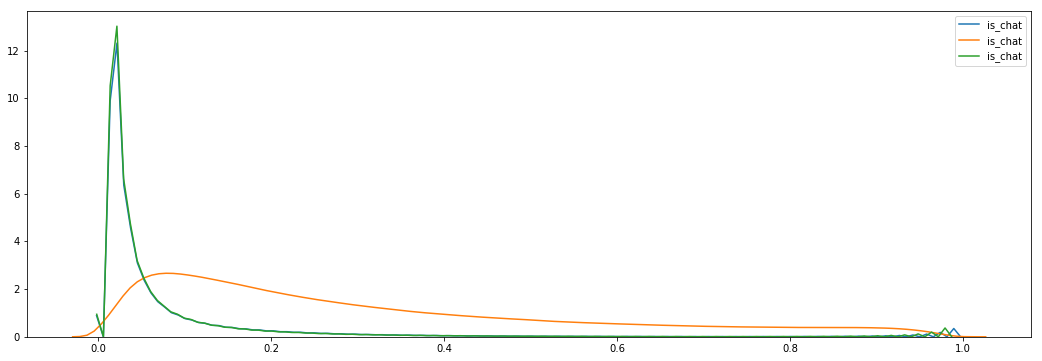

In [67]:
plt.figure(figsize=(18,6))
sns.kdeplot(sub_xgb.is_chat)
sns.kdeplot(sub_lgb.is_chat)


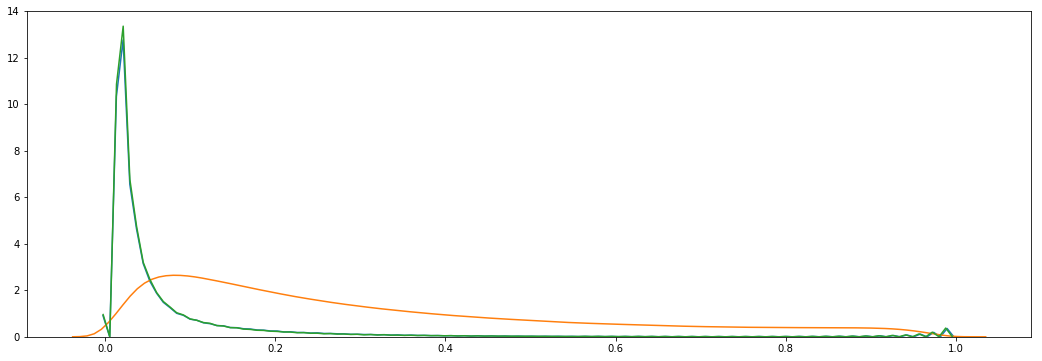

In [68]:
plt.figure(figsize=(18,6))
sns.kdeplot(oof_xgb)
sns.kdeplot(oof_lgb)

In [71]:
mix = pd.merge(sub_xgb, sub_lgb, on='id',how='left').iloc[:,1:].mean(axis=1)
sub_mix = sub_cat.copy()
sub_mix.is_chat = mix
sub_mix.to_csv('data/submission.csv', index=None)